In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K


Using TensorFlow backend.


In [2]:
#two channels, do k-bit, M-ary generalisation. starting with k=4 for 16 symbols
n = 2
k = 8
M = 2**k
R = k/n
channel_noise_dB=20
channel_noise_ratio = 10**(channel_noise_dB/10)
PD_noise_dB=20
PD_noise_ratio = 10**(PD_noise_dB/10)
CD_noise_dB=20
CD_noise_ratio = 10**(CD_noise_dB/10)
noise_mag1 = np.sqrt(1/(2*R*channel_noise_ratio))
PDnoise_mag = 1/(2*R*PD_noise_ratio) #same as the others squared because of the effect of squaring on noise magnitude
CDnoise_mag = np.sqrt(1/(2*R*CD_noise_ratio))
print('channel:',noise_mag1)
print('processing:',PDnoise_mag)

channel: 0.035355339059327376
processing: 0.00125


In [3]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])

verification checks:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [0]:
#Custom layer definition
class EnergySplitter(keras.layers.Layer):
  '''
  Creates two copies of the input, concatenated onto one dimension, each 
  multiplied by a constant. The parameter rho is trainable.
  The first copy of the input is multiplied by sqrt(1-rho), while the second is
  multiplied by sqrt(rho).
  '''
  def compute_output_shape(self,input_shape):
    return [input_shape,input_shape]
  
  def __init__(self,**kwargs):
    super(EnergySplitter,self).__init__(**kwargs)
    #initialise the splitting ratio
    self.rho=tf.Variable(
        initial_value=1.0,
        trainable=False,
        constraint=lambda t: tf.clip_by_value(t,0,1)
    )

  def call(self,inputs):
    return [K.sqrt(1-self.rho)*inputs,K.sqrt(self.rho)*inputs]

class SquareSum(keras.layers.Layer):
  '''
  returns a scalar value, the sum of the elementwise squared input
  '''
  def compute_output_shape(self, input_shape):
    return (None,1)
  
  def __init__(self, **kwargs):
    super(SquareSum,self).__init__(**kwargs)
  
  def call(self, inputs):
    return K.reshape(tf.convert_to_tensor([K.sum(K.square(inputs),axis=1)],dtype='float32'),shape=(tf.shape(inputs)[0],1))

class RectMod256(keras.layers.Layer):
  '''
  takes a 1-hot class vector as an input, outputs the corresponding rectangular 
  16-QAM baseband values, using keras operations
  '''
  def compute_output_shape(self,input_shape):
    return (input_shape[0],2)
  
  def __init__(self, **kwargs):
    super(RectMod256,self).__init__(**kwargs)
    self.coords_tensor=coords_tensor = tf.cast(tf.convert_to_tensor(
        [(-15  ,15),(-15  ,13),(-15  ,9),(-15  ,11),(-15  ,1),(-15  ,3),(-15  ,7),(-15  ,5),(-15  ,-15),(-15  ,-13),(-15  ,-9),        
         (-15  ,-11),(-15  ,-1),(-15  ,-3),(-15  ,-7),(-15  ,-5),(-13  ,15),(-13  ,13),(-13  ,9),(-13  ,11),(-13  ,1),(-13  ,3),
         (-13  ,7),(-13  ,5),(-13  ,-15),(-13  ,-13),(-13  ,-9),(-13  ,-11),(-13  ,-1),(-13  ,-3),(-13  ,-7),(-13  ,-5),(-9  ,15),
         (-9  ,13),(-9  ,9),(-9  ,11),(-9  ,1),(-9  ,3),(-9  ,7),(-9  ,5),(-9  ,-15),(-9  ,-13),(-9  ,-9),(-9  ,-11),(-9  ,-1),
         (-9  ,-3),(-9  ,-7),(-9  ,-5),(-11  ,15),(-11  ,13),(-11  ,9),(-11  ,11),(-11  ,1),(-11  ,3),(-11  ,7),(-11  ,5),(-11  ,-15),
         (-11  ,-13),(-11  ,-9),(-11  ,-11),(-11  ,-1),(-11  ,-3),(-11  ,-7),(-11  ,-5),(-1  ,15),(-1  ,13),(-1  ,9),(-1  ,11),(-1  ,1),
         (-1  ,3),(-1  ,7),(-1  ,5),(-1  ,-15),(-1  ,-13),(-1  ,-9),(-1  ,-11),(-1  ,-1),(-1  ,-3),(-1  ,-7),(-1  ,-5),(-3  ,15),
         (-3  ,13),(-3  ,9),(-3  ,11),(-3  ,1),(-3  ,3),(-3  ,7),(-3  ,5),(-3  ,-15),(-3  ,-13),(-3  ,-9),(-3  ,-11),(-3  ,-1),
         (-3  ,-3),(-3  ,-7),(-3  ,-5),(-7  ,15),(-7  ,13),(-7  ,9),(-7  ,11),(-7  ,1),(-7  ,3),(-7  ,7),(-7  ,5),(-7  ,-15),(-7  ,-13),
         (-7  ,-9),(-7  ,-11),(-7  ,-1),(-7  ,-3),(-7  ,-7),(-7  ,-5),(-5  ,15),(-5  ,13),(-5  ,9),(-5  ,11),(-5  ,1),(-5  ,3),(-5  ,7),
         (-5  ,5),(-5  ,-15),(-5  ,-13),(-5  ,-9),(-5  ,-11),(-5  ,-1),(-5  ,-3),(-5  ,-7),(-5  ,-5),(15  ,15),(15  ,13),(15  ,9),(15  ,11),
         (15  ,1),(15  ,3),(15  ,7),(15  ,5),(15  ,-15),(15  ,-13),(15  ,-9),(15  ,-11),(15  ,-1),(15  ,-3),(15  ,-7),(15  ,-5),(13  ,15),
         (13  ,13),(13  ,9),(13  ,11),(13  ,1),(13  ,3),(13  ,7),(13  ,5),(13  ,-15),(13  ,-13),(13  ,-9),(13  ,-11),(13  ,-1),(13  ,-3),
         (13  ,-7),(13  ,-5),(9  ,15),(9  ,13),(9  ,9),(9  ,11),(9  ,1),(9  ,3),(9  ,7),(9  ,5),(9  ,-15),(9  ,-13),(9  ,-9),(9  ,-11),
         (9  ,-1),(9  ,-3),(9  ,-7),(9  ,-5),(11  ,15),(11  ,13),(11  ,9),(11  ,11),(11  ,1),(11  ,3),(11  ,7),(11  ,5),(11  ,-15),
         (11  ,-13),(11  ,-9),(11  ,-11),(11  ,-1),(11  ,-3),(11  ,-7),(11  ,-5),(1  ,15),(1  ,13),(1  ,9),(1  ,11),(1  ,1),(1  ,3),
         (1  ,7),(1  ,5),(1  ,-15),(1  ,-13),(1  ,-9),(1  ,-11),(1  ,-1),(1  ,-3),(1  ,-7),(1  ,-5),(3  ,15),(3  ,13),(3  ,9),(3  ,11),
         (3  ,1),(3  ,3),(3  ,7),(3  ,5),(3  ,-15),(3  ,-13),(3  ,-9),(3  ,-11),(3  ,-1),(3  ,-3),(3  ,-7),(3  ,-5),(7  ,15),(7  ,13),
         (7  ,9),(7  ,11),(7  ,1),(7  ,3),(7  ,7),(7  ,5),(7  ,-15),(7  ,-13),(7  ,-9),(7  ,-11),(7  ,-1),(7  ,-3),(7  ,-7),(7  ,-5),
         (5  ,15),(5  ,13),(5  ,9),(5  ,11),(5  ,1),(5  ,3),(5  ,7),(5  ,5),(5  ,-15),(5  ,-13),(5  ,-9),(5  ,-11),(5  ,-1),(5  ,-3),
         (5  ,-7),(5  ,-5),]),dtype=tf.float32)

  def call(self,inputs):
    return tf.tensordot(inputs,self.coords_tensor,axes=1)
    #multiply by coords tensor

In [5]:
#Build the model:

#input
autoenc_in = keras.layers.Input(shape=(M,),name='Information_Input')

#encoder
encoder = RectMod256(name='Modulator')(autoenc_in)

#Regulariser
regulariser = keras.layers.BatchNormalization(center=False,scale=False,name='Regulariser')(encoder)

#Channel noise
channel = keras.layers.GaussianNoise(noise_mag1,name='Channel_Noise')(regulariser)

#Splitter
splitter_layer = EnergySplitter(name='Splitter')
splitter = splitter_layer(channel)

#PD processing
presquaring = SquareSum()(splitter[0])
PD_noise = keras.layers.GaussianNoise(PDnoise_mag,name='PD_Noise')(presquaring)

#CD processing
CD_noise = keras.layers.GaussianNoise(CDnoise_mag,name='CD_Noise')(splitter[1])

#Try adding pre-processing to do something with each pathway before merging
PD_preproc = keras.layers.Dense(M/2,activation='relu',name='PD_Preprocessing')(PD_noise)
CD_preproc = keras.layers.Dense(M/2,activation='relu',name='CD_Preprocessing')(CD_noise)

#Merge two inputs
Merge = keras.layers.Concatenate(axis=-1,name='Merge')([PD_preproc,CD_preproc])

#decoder
decoder_0 = keras.layers.Dense(M/2,activation='relu',name='Decoder_Processing')(Merge)
#decoder_ins= keras.layers.Dense(M,activation='relu')(decoder_0)
decoder_1 = keras.layers.Dense(M,activation='softmax',name='Decoder_Output')(decoder_0)

#Put it together
autoencoder = keras.models.Model(autoenc_in,decoder_1)
print(autoencoder.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Information_Input (InputLayer)  [(None, 256)]        0                                            
__________________________________________________________________________________________________
Modulator (RectMod256)          (None, 2)            0           Information_Input[0][0]          
__________________________________________________________________________________________________
Regulariser (BatchNormalization (None, 2)            4           Modulator[0][0]                  
__________________________________________________________________________________________________
Channel_Noise (GaussianNoise)   (None, 2)            0           Regulariser[0][0]                
______________________________________________________________________________________________

In [0]:
#keras.utils.plot_model(
#    autoencoder,
#    to_file='modelmap.png'
#)

In [0]:
adam = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [8]:
autoencoder.fit(xs,xs,batch_size=M*100,epochs=30)
autoencoder.fit(xs,xs,batch_size=M*100,epochs=30)
autoencoder.fit(xs,xs,batch_size=M*100,epochs=30)

Epoch 1/30
100/100 [==============================] - 27s 273ms/step - loss: 4.3116
Epoch 2/30
100/100 [==============================] - 27s 272ms/step - loss: 2.2672
Epoch 3/30
100/100 [==============================] - 27s 271ms/step - loss: 1.2934
Epoch 4/30
100/100 [==============================] - 27s 271ms/step - loss: 0.8204
Epoch 5/30
100/100 [==============================] - 27s 272ms/step - loss: 0.5734
Epoch 6/30
100/100 [==============================] - 27s 273ms/step - loss: 0.4379
Epoch 7/30
100/100 [==============================] - 27s 274ms/step - loss: 0.3622
Epoch 8/30
100/100 [==============================] - 27s 274ms/step - loss: 0.3126
Epoch 9/30
100/100 [==============================] - 27s 274ms/step - loss: 0.2829
Epoch 10/30
100/100 [==============================] - 27s 273ms/step - loss: 0.2599
Epoch 11/30
100/100 [==============================] - 27s 274ms/step - loss: 0.2471
Epoch 12/30
100/100 [==============================] - 27s 272ms/step - lo

In [0]:
#Make subordinate models for plotting/simulation
encoder = keras.models.Model(autoenc_in,regulariser)

#Make the decoder from the concatenation onwards: 
#deco_in = [keras.layers.Input(shape=(1,)),keras.layers.Input(shape=(2,))]
deco_PD_in = keras.layers.Input(shape=(1,))
deco_CD_in = keras.layers.Input(shape=(2,))
deco_PD = autoencoder.layers[-5](deco_PD_in)
deco_CD = autoencoder.layers[-4](deco_CD_in)
deco = autoencoder.layers[-3]([deco_PD,deco_CD])
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
decoder = keras.models.Model([deco_PD_in,deco_CD_in],deco)

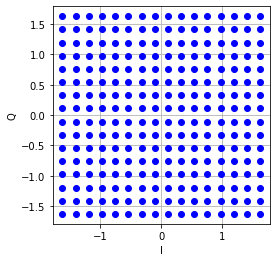

rho = 1.0
PD proportion = 0.0
CD proportion = 1.0


In [10]:
#Plot modulation scheme
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
data = data.reshape(M,2,1)
plt.plot(data[:,0],data[:,1],'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('square')
plt.show()
rho=splitter_layer.get_weights()[0]
print('rho =',rho)
print('PD proportion =',np.sqrt(1-rho))
print('CD proportion =',np.sqrt(rho))

In [11]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1,0,0]**2+data[iter1,1,0]**2
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use/n)
print('scaling, should be around 1, =',scaling)

1.999596957832978
scaling, should be around 1, = 0.9998992343813895


In [12]:
'''
# Monte-Carlo Modelling
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(0,16,1.5))
EbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])
EbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])
ser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))
for iter1 in range(len(EbNo_range_dB_channel)):
  for iter2 in range(len(EbNo_range_dB_PD)):
    for iter3 in range(len(EbNo_range_dB_CD)):
      # Create channel noise vector
      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)
      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
      noise_channel = noise_std_channel*np.random.randn(dat_size,n)
      # Create PD noise vector
      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)
      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling
      noise_PD = noise_std_PD*np.random.randn(dat_size)
      # Create CD noise vector
      EbNo_CD = 10**(EbNo_range_dB_CD[iter3]/10)
      noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
      noise_CD = noise_std_CD*np.random.randn(dat_size,n)
      # Get encoder output and add channel noise
      channel_out=encoder.predict(xs)+noise_channel
      # PD section
      PD_input = channel_out*np.sqrt(1-rho)
      PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
      PD_out = PD_squared+noise_PD
      # CD section, literally just add more noise to scaled input
      CD_out = channel_out*np.sqrt(rho)+noise_CD
      # Prediction based on noises
      prediction = decoder.predict([PD_out,CD_out])
      prediction = np.argmax(prediction,axis=1)
      wrong = (prediction != rand_data)
      count=np.sum(wrong)
      index=iter3+len(EbNo_range_dB_CD)*iter2+len(EbNo_range_dB_CD)*len(EbNo_range_dB_PD)*iter1
      ser[index]=count/dat_size
      print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_range_dB_PD[iter2],'| CD EbNo(dB):',EbNo_range_dB_CD[iter3],'| SER',ser[index])
'''

"\n# Monte-Carlo Modelling\nrho=splitter_layer.get_weights()[0]\n# Three ebno amounts, which can vary separately. Express as a list even if a \n# single value. In practice, only make longer than 1, fix the other two for plotting\nEbNo_range_dB_channel = list(np.arange(0,16,1.5))\nEbNo_range_dB_PD = list([10*np.log10(PD_noise_ratio)])\nEbNo_range_dB_CD = list([10*np.log10(CD_noise_ratio)])\nser = [None]*(len(EbNo_range_dB_channel)*len(EbNo_range_dB_PD)*len(EbNo_range_dB_CD))\nfor iter1 in range(len(EbNo_range_dB_channel)):\n  for iter2 in range(len(EbNo_range_dB_PD)):\n    for iter3 in range(len(EbNo_range_dB_CD)):\n      # Create channel noise vector\n      EbNo_channel = 10**(EbNo_range_dB_channel[iter1]/10)\n      noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling\n      noise_channel = noise_std_channel*np.random.randn(dat_size,n)\n      # Create PD noise vector\n      EbNo_PD = 10**(EbNo_range_dB_PD[iter2]/10)\n      noise_std_PD = np.sqrt(1/(2*R*EbNo_PD))*scaling\n      noi

In [0]:
dat_size=M*1000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)

In [14]:
# Monte-Carlo Modelling for processing noise consistent relative to channel noise
rho=splitter_layer.get_weights()[0]
# Three ebno amounts, which can vary separately. Express as a list even if a 
# single value. In practice, only make longer than 1, fix the other two for plotting
EbNo_range_dB_channel = list(np.arange(16,27,1))
EbNo_dB_PD_diff = PD_noise_dB - channel_noise_dB
EbNo_dB_CD_diff = CD_noise_dB - channel_noise_dB
ser = [None]*len(EbNo_range_dB_channel)
for iter1 in range(len(EbNo_range_dB_channel)):
  # Create channel noise vector
  EbNo_channel_dB=EbNo_range_dB_channel[iter1]
  EbNo_channel = 10**(EbNo_channel_dB/10)
  noise_std_channel = np.sqrt(1/(2*R*EbNo_channel))*scaling
  noise_channel = noise_std_channel*np.random.randn(dat_size,n)
  # Create PD noise vector
  EbNo_PD = 10**((EbNo_dB_PD_diff+EbNo_channel_dB)/10)
  noise_std_PD = 1/(2*R*EbNo_PD)*scaling
  noise_PD = noise_std_PD*np.random.randn(dat_size)
  # Create CD noise vector
  EbNo_CD = 10**((EbNo_dB_CD_diff+EbNo_channel_dB)/10)
  noise_std_CD = np.sqrt(1/(2*R*EbNo_CD))*scaling
  noise_CD = noise_std_CD*np.random.randn(dat_size,n)
  # Get encoder output and add channel noise
  channel_out=encoder.predict(xs)+noise_channel
  # PD section
  PD_input = channel_out*np.sqrt(1-rho)
  PD_squared = np.array([PD_input[i][0]*PD_input[i][0]+PD_input[i][1]*PD_input[i][1] for i in range(len(PD_input))])
  PD_out = PD_squared+noise_PD
  # CD section, literally just add more noise to scaled input
  CD_out = channel_out*np.sqrt(rho)+noise_CD
  # Prediction based on noises
  prediction = decoder.predict([PD_out,CD_out])
  prediction = np.argmax(prediction,axis=1)
  wrong = (prediction != rand_data)
  count=np.sum(wrong)
  ser[iter1]=count/dat_size
  print('Channel EbNo(dB):',EbNo_range_dB_channel[iter1],'| PD EbNo(dB):',EbNo_dB_PD_diff+EbNo_channel_dB,'| CD EbNo(dB):',EbNo_dB_CD_diff+EbNo_channel_dB,'| SER',ser[iter1])

Channel EbNo(dB): 16 | PD EbNo(dB): 16 | CD EbNo(dB): 16 | SER 0.29926953125
Channel EbNo(dB): 17 | PD EbNo(dB): 17 | CD EbNo(dB): 17 | SER 0.22276171875
Channel EbNo(dB): 18 | PD EbNo(dB): 18 | CD EbNo(dB): 18 | SER 0.15663671875
Channel EbNo(dB): 19 | PD EbNo(dB): 19 | CD EbNo(dB): 19 | SER 0.10144140625
Channel EbNo(dB): 20 | PD EbNo(dB): 20 | CD EbNo(dB): 20 | SER 0.05881640625
Channel EbNo(dB): 21 | PD EbNo(dB): 21 | CD EbNo(dB): 21 | SER 0.03053515625
Channel EbNo(dB): 22 | PD EbNo(dB): 22 | CD EbNo(dB): 22 | SER 0.01329296875
Channel EbNo(dB): 23 | PD EbNo(dB): 23 | CD EbNo(dB): 23 | SER 0.00515625
Channel EbNo(dB): 24 | PD EbNo(dB): 24 | CD EbNo(dB): 24 | SER 0.00151953125
Channel EbNo(dB): 25 | PD EbNo(dB): 25 | CD EbNo(dB): 25 | SER 0.00036328125
Channel EbNo(dB): 26 | PD EbNo(dB): 26 | CD EbNo(dB): 26 | SER 6.640625e-05


ValueError: ignored

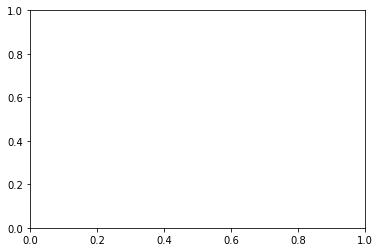

In [15]:
## sandbox
#P=100
##P_dB=20
##ratio of sqrt(P) to 1 is fixed at 0.1
##want: np.sqrt(1/(2*R*channel_noise_ratio)) = 0.1 with transmit power of 1
##1/(2*R*channel_noise_ratio)=0.01
##2*R*channel_noise_ratio = 100
##channel_noise_ratio = 100/6=16.6
##channel_noise_dB=10*np.log10(16.6)
##print(channel_noise_dB) #=12.2
##So the difference is 7.8 - add 7.8dB to the EbNo value and you're good because dB are cool
##Pull in SER from the designed modulation scheme 
#designedModSER = [0.1238921875, 0.0758078125, 0.0417609375, 0.0199765625, 0.0082046875, 0.0027953125, 0.0007140625, 0.0001734375]
#CDrectSER = [0.204797, 0.141373, 0.09003, 0.051446, 0.025708, 0.010862, 0.003649, 0.000997]
#P_dB = np.asarray(EbNo_range_dB_channel)+7.8 -20 #P value in dB
#plt.plot(P_dB,CDrectSER,'kv:',P_dB,ser,'ro-',P_dB,designedModSER,'bx--')
##plt.plot(P_dB,ser,'ro-')
#plt.yscale('log')
#plt.grid(which='minor',linestyle=':')
#plt.grid('major',linestyle='-')
#plt.title('SER vs equivalent transmission power dB')
#plt.xlabel('P(dB)')
#plt.ylabel('SER')
#QAMlabel='Rectangular 64-QAM (rho='+"{:.3f}".format(rho)+')'
#plt.legend(['Rectangular 64-QAM (rho=1)',QAMlabel,'Designed Modulation Scheme'])


In [16]:
#sandbox
print(ser)
print(rho)

[0.29926953125, 0.22276171875, 0.15663671875, 0.10144140625, 0.05881640625, 0.03053515625, 0.01329296875, 0.00515625, 0.00151953125, 0.00036328125, 6.640625e-05]
1.0
